# 2. End-to-End Pipeline Prototyping

**Objective:** This notebook serves as a workbench for building and testing the entire machine learning pipeline. Here, we prototype the feature extraction, model training, and prediction logic in an interactive environment before refactoring the final code into reusable `.py` scripts.

## 2.1. Setup, Imports, and Data Loading

We'll start by importing all necessary libraries and loading the development dataset. We will also perform the initial data cleaning steps identified previously.

In [185]:
import numpy as np
import pandas as pd
import random
from scipy.stats import skew, kurtosis

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import librosa
import librosa.display

In [186]:
DEVELOPMENT_PATH = Path("../data/development.csv")

if DEVELOPMENT_PATH.exists():
    dev_df = pd.read_csv(DEVELOPMENT_PATH, index_col=0)
else:
    print(f"Errore: File non trovato al percorso {DEVELOPMENT_PATH}")
    # Initialize an empty DataFrame
    dev_df = pd.DataFrame()

In [187]:
class TempoCleaner(BaseEstimator, TransformerMixin):
    """
    A custom transformer to clean the 'tempo' column.
    It checks if the column is of object type, and if so, it strips
    the brackets and converts it to a numeric type.
    """
    def __init__(self, column_name='tempo', verbose=False):
        self.column_name = column_name
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()

        if self.column_name in X_.columns and X_[self.column_name].dtype == 'object':
            if self.verbose:
                print(f"Cleaning column: '{self.column_name}'")
            X_[self.column_name] = pd.to_numeric(
                X_[self.column_name].str.strip('[]'),
                errors='coerce'
            )
        
        return X_

## 2.2. Strategic Preprocessing

Here we apply the feature engineering and selection decisions from our EDA.

* **Feature Selection:** Drop redundant columns (e.g., `num_characters`).
* **Feature Engineering:** Group rare categories in the `ethnicity` feature into an "Other" class.
* **Data Splitting:** Separate the features (`X`) from the target variable (`y`).

In [188]:
class RedundantFeatureDropper(BaseEstimator, TransformerMixin):
    """
    A custom transformer to drop specified redundant columns from a DataFrame.
    """
    def __init__(self, columns_to_drop, verbose=False):
        if not isinstance(columns_to_drop, list):
            raise ValueError("'columns_to_drop' must be a list of column names.")
        self.columns_to_drop = columns_to_drop
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        if self.verbose:
            print(f"Dropping redundant columns: {self.columns_to_drop}")
        X_ = X_.drop(columns=self.columns_to_drop, errors='ignore')
        
        return X_

In [189]:
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """
    A custom transformer to group rare categorical features into a single 'Other' category.
    It identifies the top N most frequent categories during fit and applies this
    grouping during transform.
    """
    def __init__(self, columns, n_top_categories=10, verbose=False):
        self.columns = columns
        self.n_top_categories = n_top_categories
        self.top_categories_ = {}
        self.verbose = verbose

    def fit(self, X, y=None):
        for col in self.columns:
            top_cats = X[col].value_counts().nlargest(self.n_top_categories).index.tolist()
            self.top_categories_[col] = top_cats
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        
        if self.verbose:
            print(f"Grouping rare categories for columns: {self.columns}")
        
        for col in self.columns:
            # Sostituisce le categorie non principali con 'Other'
            top_cats = self.top_categories_.get(col)
            if top_cats:
                X_[col] = np.where(X_[col].isin(top_cats), X_[col], 'Other')
        
        return X_

## 2.3. Building the Preprocessing Pipeline with `ColumnTransformer`

This is the core of our preprocessing. We'll use `ColumnTransformer` to apply different transformations to different types of columns:
1.  **Numerical Features:** Apply `StandardScaler`.
2.  **Categorical Features:** Apply `OneHotEncoder`.

This ensures that each feature type receives the correct treatment.

In [190]:
REDUNDANT_COLS = ['num_characters']
CATEGORICAL_COLS_TO_GROUP = ['ethnicity']
NUMERICAL_FEATURES = [
    'mean_pitch', 'max_pitch', 'min_pitch', 'jitter', 'shimmer',
    'energy', 'zcr_mean', 'spectral_centroid_mean', 'tempo', 'hnr',
    'num_words', 'num_pauses', 'silence_duration'
]
CATEGORICAL_FEATURES = ['gender', 'ethnicity']

final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES)
    ],
    remainder='drop'
)

preprocessing_pipeline = Pipeline(steps=[
    ('tempo_cleaner', TempoCleaner(column_name='tempo')),
    ('feature_dropper', RedundantFeatureDropper(columns_to_drop=REDUNDANT_COLS)),
    ('rare_grouper', RareCategoryGrouper(columns=CATEGORICAL_COLS_TO_GROUP, n_top_categories=10)),
    ('final_preprocessor', final_preprocessor)
])

preprocessing_pipeline

,steps,"[('tempo_cleaner', ...), ('feature_dropper', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,column_name,'tempo'
,verbose,False
,columns_to_drop,['num_characters']
,verbose,False
,columns,['ethnicity']
,n_top_categories,10
,verbose,False


## 2.4. Model Definition with Integrated Target Transformation

In this step, we define our final estimator. We use `TransformedTargetRegressor` to wrap our chosen regression model. This allows us to specify the target transformation (`func=np.log1p`) and its inverse (`inverse_func=np.expm1`) directly as part of the model definition, automating the entire process.

In [191]:
base_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

final_model = TransformedTargetRegressor(
    regressor=base_regressor,
    func=(lambda x: x),           
    inverse_func=(lambda x: x)    
)

final_model

,regressor,RandomForestR...ndom_state=42)
,transformer,None
,func,<function <la...t 0x12e8aaac0>
,inverse_func,<function <la...t 0x12df71e40>
,check_inverse,True
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


## 2.5. Building the Full End-to-End Pipeline

Now we assemble all the pieces. We combine the feature preprocessor (the `ColumnTransformer` from step 2.3) and the final_model (the `TransformedTargetRegressor` from step 2.4) into a single, unified scikit-learn Pipeline. This object encapsulates the entire workflow, from raw data to a final prediction in the original scale.

In [192]:
full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('model', final_model)
])

full_pipeline

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('tempo_cleaner', ...), ('feature_dropper', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,column_name,'tempo'
,verbose,False
,columns_to_drop,['num_characters']


## 2.6. Model Selection

Objective: Now that we have a baseline preprocessing pipeline, we will conduct a "race" between several different regression models. We will use K-Fold Cross-Validation to evaluate each model with its default parameters to identify which architecture is most promising for our dataset.

In [193]:
X = dev_df.drop(columns=['age'])
y = dev_df['age']

param_grid = [
    # Esperimento 1: Linear Regression (nessun iperparametro da testare)
    {
        'model__regressor': [LinearRegression()]
    },
    
    # Esperimento 2: Ridge Regression
    {
        'model__regressor': [Ridge()],
        'model__regressor__alpha': [0.1, 1.0, 10.0]  # Prova diversi valori di regolarizzazione
    },

    # Esperimento 3: Support Vector Regressor (SVR)
    {
        'model__regressor': [SVR()],
        'model__regressor__kernel': ['linear', 'rbf'],
        'model__regressor__C': [1, 10]
    },

    # Esperimento 4: Random Forest Regressor
    {
        'model__regressor': [RandomForestRegressor(random_state=42)],
        'model__regressor__n_estimators': [100, 200]
    },

    # Esperimento 5: HistGradientBoosting Regressor
    {
    'model__regressor': [HistGradientBoostingRegressor(random_state=42)],
    'model__regressor__learning_rate': [0.05, 0.1],      
    'model__regressor__max_leaf_nodes': [31, 50] 
    }
]


cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X, y)

results = grid_search.cv_results_
results_df = pd.DataFrame(results)
report_df = results_df[[
    'rank_test_score',
    'param_model__regressor',
    'mean_test_score',
    'std_test_score'
]].sort_values(by='rank_test_score')

report_df = report_df.rename(columns={
    'rank_test_score': 'Rank',
    'param_model__regressor': 'Model',
    'mean_test_score': 'Mean RMSE',
    'std_test_score': 'Std Dev (RMSE)'
})
report_df['Mean RMSE'] = -report_df['Mean RMSE']
report_df['Model'] = report_df['Model'].astype(str).str.split('(').str[0]

print("--- Report Dettagliato dei Risultati della GridSearchCV ---")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(report_df)

full_pipeline = grid_search.best_estimator_

print("\n--- Pipeline Con Miglior Modello ---")
full_pipeline

Fitting 5 folds for each of 14 candidates, totalling 70 fits
--- Report Dettagliato dei Risultati della GridSearchCV ---
    Rank                          Model  Mean RMSE  Std Dev (RMSE)
10     1  HistGradientBoostingRegressor  10.488219        0.503160
11     2  HistGradientBoostingRegressor  10.550934        0.455182
9      3          RandomForestRegressor  10.590829        0.497254
8      4          RandomForestRegressor  10.616117        0.458664
12     5  HistGradientBoostingRegressor  10.648733        0.431090
7      6                            SVR  10.705944        0.573512
3      7                          Ridge  10.724577        0.361522
2      8                          Ridge  10.729502        0.361972
1      9                          Ridge  10.730502        0.362145
0     10               LinearRegression  10.730620        0.362166
13    11  HistGradientBoostingRegressor  10.778806        0.493979
6     12                            SVR  11.193925        0.521065
4     13

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('tempo_cleaner', ...), ('feature_dropper', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,column_name,'tempo'
,verbose,False
,columns_to_drop,['num_characters']


## 2.7. Preprocessing Optimization

Objective: With the best model selected (HistGradientBoostingRegressor), we will now run a second "race" to optimize the preprocessing pipeline. We will test different scaling techniques (StandardScaler, MinMaxScaler, RobustScaler, etc.) to find the combination of preprocessing and modeling that yields the lowest RMSE.

In [194]:
param_grid = {
    'preprocessing__final_preprocessor__num': [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler(),
        PowerTransformer()
    ]
}

cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    full_pipeline, param_grid, cv=cv_strategy, scoring='neg_root_mean_squared_error', verbose=1
)

grid_search.fit(X, y)

print("\n--- Report Dettagliato dei Risultati della Gara di Preprocessing ---")
results_df = pd.DataFrame(grid_search.cv_results_)

report_df = results_df[[
    'rank_test_score', 'param_preprocessing__final_preprocessor__num', 'mean_test_score', 'std_test_score'
]].sort_values(by='rank_test_score')

report_df = report_df.rename(columns={
    'rank_test_score': 'Rank',
    'param_preprocessing__final_preprocessor__num': 'Scaler',
    'mean_test_score': 'Mean RMSE',
    'std_test_score': 'Std Dev (RMSE)'
})

report_df['Mean RMSE'] = -report_df['Mean RMSE']
report_df['Scaler'] = report_df['Scaler'].apply(lambda x: x.__class__.__name__)

pd.set_option('display.width', 1000)
print(report_df)

full_pipeline = grid_search.best_estimator_

print("\n--- Pipeline Con Miglior Scaler ---")
full_pipeline

Fitting 5 folds for each of 4 candidates, totalling 20 fits

--- Report Dettagliato dei Risultati della Gara di Preprocessing ---
   Rank            Scaler  Mean RMSE  Std Dev (RMSE)
1     1      MinMaxScaler  10.476861        0.541286
3     2  PowerTransformer  10.485733        0.471648
0     3    StandardScaler  10.488219        0.503160
2     4      RobustScaler  10.495506        0.498509

--- Pipeline Con Miglior Scaler ---


,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('tempo_cleaner', ...), ('feature_dropper', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,column_name,'tempo'
,verbose,False
,columns_to_drop,['num_characters']


## 2.6. Dimensionality Reduction Analysis (PCA)

Objective: In this section, we investigate whether using Principal Component Analysis (PCA) can improve performance. We will train our best pipeline with a varying number of principal components and plot the resulting RMSE to determine if dimensionality reduction is beneficial for this problem.

Avvio della ricerca del numero ottimale di componenti PCA...
Fitting 5 folds for each of 13 candidates, totalling 65 fits

Analisi completata. Generazione del grafico...


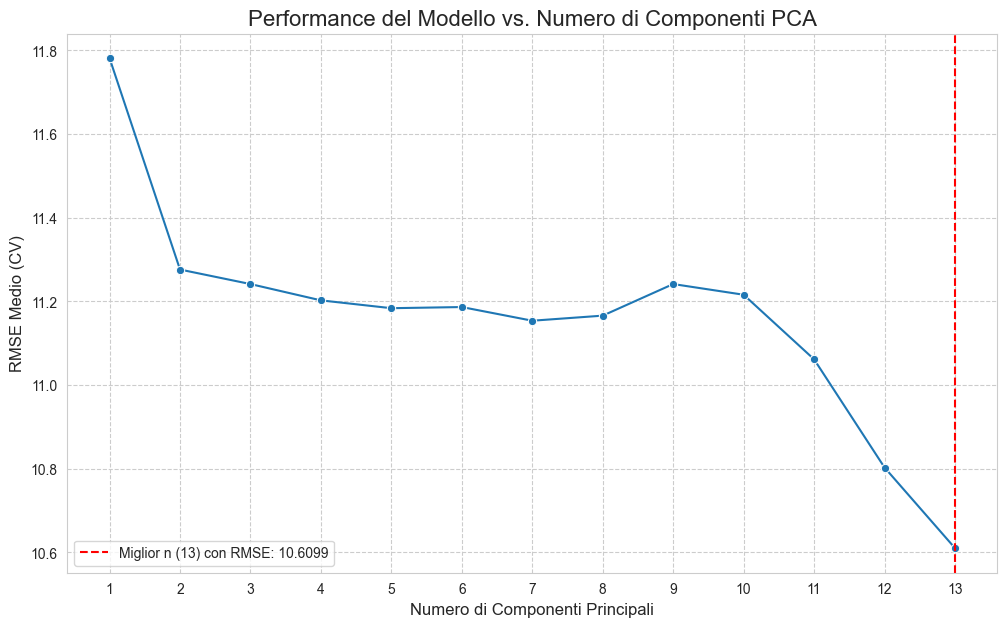

In [195]:
param_grid = [
    {
    'preprocessing__final_preprocessor__num': [
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('pca', PCA())
        ])
    ],
    'preprocessing__final_preprocessor__num__pca__n_components': range(1, len(NUMERICAL_FEATURES) + 1)
    }
]

cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search_pca = GridSearchCV(
    full_pipeline, param_grid, cv=cv_strategy, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1
)

print("Avvio della ricerca del numero ottimale di componenti PCA...")
grid_search_pca.fit(X, y)

# --- 4. Creazione del Grafico dai Risultati ---
print("\nAnalisi completata. Generazione del grafico...")
results_df = pd.DataFrame(grid_search_pca.cv_results_)
n_components_range_results = results_df['param_preprocessing__final_preprocessor__num__pca__n_components']
results_rmse = -results_df['mean_test_score']

plt.figure(figsize=(12, 7))
sns.lineplot(x=n_components_range_results, y=results_rmse, marker='o')
plt.title('Performance del Modello vs. Numero di Componenti PCA', fontsize=16)
plt.xlabel('Numero di Componenti Principali', fontsize=12)
plt.ylabel('RMSE Medio (CV)', fontsize=12)
plt.xticks(n_components_range_results)
plt.grid(True, which='both', linestyle='--')

best_n = grid_search_pca.best_params_['preprocessing__final_preprocessor__num__pca__n_components']
best_rmse = -grid_search_pca.best_score_
plt.axvline(best_n, color='red', linestyle='--', label=f'Miglior n ({best_n}) con RMSE: {best_rmse:.4f}')
plt.legend()
plt.show()

# no PCA needed

## 2.7. Final Analysis of the Optimized Model

Objective: With the optimal model and preprocessing pipeline finalized, we will conduct a deeper analysis to understand its behavior, strengths, and weaknesses.

### 2.7.1. Error Analysis

We will analyze the model's prediction errors to identify any systematic patterns. This involves plotting predictions vs. true values and residuals vs. true values to see where the model makes its biggest mistakes.

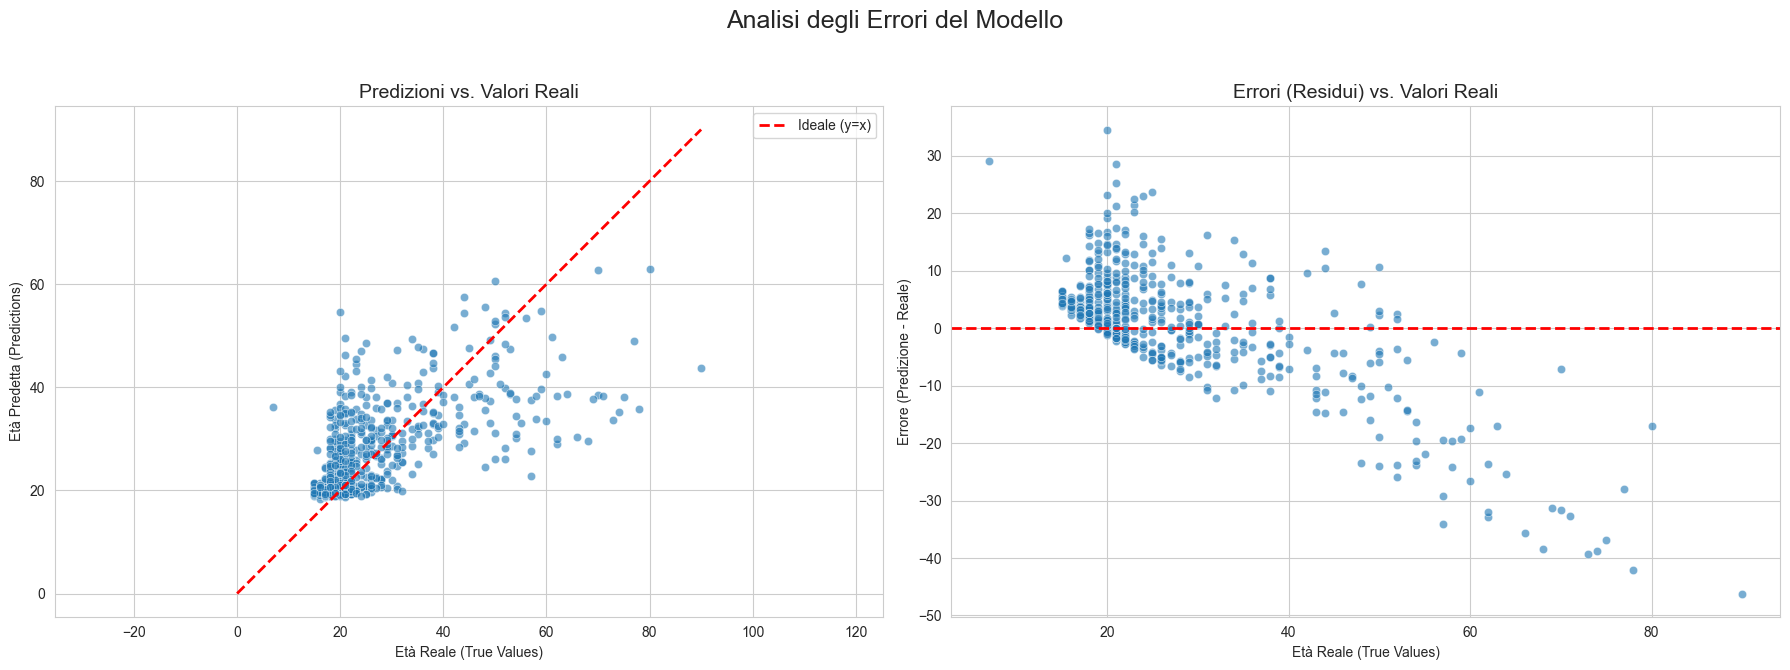

In [196]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

full_pipeline.fit(X_train, y_train)
y_pred = full_pipeline.predict(X_val)

errors = y_pred - y_val

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.set_style("whitegrid")
fig.suptitle('Analisi degli Errori del Modello', fontsize=18)

sns.scatterplot(x=y_val, y=y_pred, ax=axes[0], alpha=0.6)
axes[0].set_title('Predizioni vs. Valori Reali', fontsize=14)
axes[0].set_xlabel('Età Reale (True Values)')
axes[0].set_ylabel('Età Predetta (Predictions)')

max_val = max(y_val.max(), y_pred.max())
axes[0].plot([0, max_val], [0, max_val], color='red', linestyle='--', lw=2, label='Ideale (y=x)')
axes[0].legend()
axes[0].axis('equal')

sns.scatterplot(x=y_val, y=errors, ax=axes[1], alpha=0.6)
axes[1].axhline(0, color='red', linestyle='--', lw=2) # Linea dello zero errore
axes[1].set_title('Errori (Residui) vs. Valori Reali', fontsize=14)
axes[1].set_xlabel('Età Reale (True Values)')
axes[1].set_ylabel('Errore (Predizione - Reale)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2.7.2. Feature Importance Analysis

We will analyze the permutation importances to understand which features the final model relies on the most. This provides a definitive ranking of the most predictive features in our current dataset.

In [197]:
full_pipeline.fit(X_train, y_train)

result = permutation_importance(
    full_pipeline,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'feature': X_val.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std,
}).sort_values(by='importance_mean', ascending=False)
print(perm_importance_df)

                   feature  importance_mean  importance_std
16        silence_duration         2.383457        0.249560
2                ethnicity         0.895854        0.137752
15              num_pauses         0.547081        0.143898
10  spectral_centroid_mean         0.275719        0.116545
9                 zcr_mean         0.227664        0.122307
6                   jitter         0.165210        0.112317
12                     hnr         0.133216        0.065090
1                   gender         0.107786        0.038609
5                min_pitch         0.047232        0.039764
3               mean_pitch         0.045796        0.066259
8                   energy         0.006565        0.045517
7                  shimmer         0.003199        0.081132
14          num_characters         0.000000        0.000000
0            sampling_rate         0.000000        0.000000
17                    path         0.000000        0.000000
13               num_words        -0.000

## 2.8 Feature Extraction

In [203]:
class AudioFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Estrae un set ricco di feature audio (MFCCs, Chroma, Spectral Contrast)
    e le loro statistiche aggregate da file audio.
    Progettato per essere inserito in una pipeline di scikit-learn.
    """
    def __init__(self, audio_dir, n_mfcc=20):
        self.audio_dir = audio_dir
        self.n_mfcc = n_mfcc
        
        self.stats_funcs = [np.mean, np.std, skew, kurtosis, np.min, np.max]
        self.stats_names = ['mean', 'std', 'skew', 'kurtosis', 'min', 'max']
        
        self._feature_names = self._generate_feature_names()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print("Inizio estrazione nuove feature audio...")
        audio_dir_path = Path(self.audio_dir)

        features_list = []

        for file_path in X['path']:
            try:
                full_path = audio_dir_path / file_path
                y_audio, sr = librosa.load(full_path, sr=None)

                mfccs = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=self.n_mfcc)
                mfccs_delta = librosa.feature.delta(mfccs)
                mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
                chroma = librosa.feature.chroma_stft(y=y_audio, sr=sr)
                spectral_contrast = librosa.feature.spectral_contrast(y=y_audio, sr=sr)

                all_stats = []
                for features in [mfccs, mfccs_delta, mfccs_delta2, chroma, spectral_contrast]:
                    stats = np.array([func(features, axis=1) for func in self.stats_funcs]).flatten()
                    all_stats.append(stats)
                
                combined_features = np.concatenate(all_stats)
                features_list.append(combined_features)

            except Exception as e:
                print(f"Errore nel processare {file_path}: {e}")
                features_list.append(np.full(len(self._feature_names), np.nan))
        
        new_features_df = pd.DataFrame(features_list, columns=self._feature_names, index=X.index)

        print("Estrazione completata.")
        return pd.concat([X, new_features_df], axis=1)

    def _generate_feature_names(self):
        names = []
        
        feature_groups = {
            'mfcc': self.n_mfcc,
            'mfcc_delta': self.n_mfcc,
            'mfcc_delta2': self.n_mfcc,
            'chroma': 12, # Chroma ha sempre 12 feature
            'spec_contrast': 7 # Spectral contrast ha sempre 7 feature
        }
        
        for prefix, num_features in feature_groups.items():
            for i in range(num_features):
                for stat_name in self.stats_names:
                    names.append(f"{prefix}_{stat_name}_{i+1}")
                    
        return names

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            raise ValueError("input_features must be provided to get_feature_names_out")
        
        return np.concatenate([np.array(input_features), np.array(self._feature_names)])

In [204]:
AUDIO_DIR = '../data'
audio_extractor_for_names = AudioFeatureExtractor(audio_dir=AUDIO_DIR)
new_audio_feature_names = audio_extractor_for_names._generate_feature_names()

FINAL_NUMERICAL_FEATURES = NUMERICAL_FEATURES + new_audio_feature_names

FINAL_NUMERICAL_FEATURES

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

final_preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, FINAL_NUMERICAL_FEATURES),
    ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES)
])

final_pipeline_with_audio = Pipeline(steps=[
    ('audio_feature_extractor', AudioFeatureExtractor(audio_dir=AUDIO_DIR)),
    ('tempo_cleaner', TempoCleaner(column_name='tempo')),
    ('feature_dropper', RedundantFeatureDropper(columns_to_drop=['num_characters', 'path'])),
    ('rare_grouper', RareCategoryGrouper(columns=['ethnicity'], n_top_categories=10)),
    ('preprocessor', final_preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42))
])

print("--- Pipeline Finale con Feature Audio Pronta ---")
final_pipeline_with_audio

--- Pipeline Finale con Feature Audio Pronta ---


,steps,"[('audio_feature_extractor', ...), ('tempo_cleaner', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,audio_dir,'../data'
,n_mfcc,20
,column_name,'tempo'
,verbose,False
,columns_to_drop,"['num_characters', 'path']"
,verbose,False
,columns,['ethnicity']


In [206]:
OUTPUT_PATH = Path("../data/development_with_audio_features.csv")

audio_extractor = AudioFeatureExtractor(audio_dir=AUDIO_DIR)
dev_extracted_df = audio_extractor.fit_transform(dev_df)

dev_extracted_df.to_csv(OUTPUT_PATH, index=False)

print(f"\nOperazione completata! Il dataset arricchito è stato salvato in '{OUTPUT_PATH}'.")
print(f"Nuove dimensioni del DataFrame: {dev_extracted_df.shape}")

Inizio estrazione nuove feature audio...
Estrazione completata.

Operazione completata! Il dataset arricchito è stato salvato in '../data/development_with_audio_features.csv'.
Nuove dimensioni del DataFrame: (2933, 493)


## Hyperparameter Tuning

In [ ]:
final_pipeline_with_audio = Pipeline(steps=[
    #('audio_feature_extractor', AudioFeatureExtractor(audio_dir=AUDIO_DIR)), Audio feature extraction is already done
    ('tempo_cleaner', TempoCleaner(column_name='tempo')),
    ('feature_dropper', RedundantFeatureDropper(columns_to_drop=['num_characters', 'path'])),
    ('rare_grouper', RareCategoryGrouper(columns=['ethnicity'], n_top_categories=10)),
    ('preprocessor', final_preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42))
])

if OUTPUT_PATH.exists():
    dev_extracted_df = pd.read_csv(OUTPUT_PATH, index_col=False)
else:
    print(f"Errore: File non trovato al percorso {OUTPUT_PATH}")
    # Initialize an empty DataFrame
    dev_extracted_df = pd.DataFrame()

X_extracted = dev_extracted_df.drop(columns=['age'])
y_extracted = dev_extracted_df['age']

param_grid = {
    'model__learning_rate': [0.02, 0.05, 0.07],      
    'model__max_iter': [200, 300, 400],            
    'model__max_leaf_nodes': [20, 31, 40],         
    'model__l2_regularization': [0.0]              
}

cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

final_grid_search = GridSearchCV(
    estimator=final_pipeline_with_audio,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

print("Avvio dell'hyperparameter tuning finale...")
final_grid_search.fit(X_extracted, y_extracted)

print("\n--- Tuning Completato ---")
print(f"Miglior Punteggio RMSE (CV): {-final_grid_search.best_score_:.4f}")
print("Migliori Parametri Trovati:")
print(final_grid_search.best_params_)


final_tuned_pipeline = final_grid_search.best_estimator_
final_tuned_pipeline

Avvio dell'hyperparameter tuning finale...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

--- Tuning Completato ---
Miglior Punteggio RMSE (CV): 9.6753
Migliori Parametri Trovati:
{'model__l2_regularization': 0.0, 'model__learning_rate': 0.05, 'model__max_iter': 200, 'model__max_leaf_nodes': 31}


,steps,"[('tempo_cleaner', ...), ('feature_dropper', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,column_name,'tempo'
,verbose,False
,columns_to_drop,"['num_characters', 'path']"
,verbose,False
,columns,['ethnicity']
,n_top_categories,10
,verbose,False


## 2.7. Final Prototype Evaluation

After cross-validation, we will train the final pipeline on the entire development set. While we don't have the labels for the official `evaluation.csv`, this step simulates the final training process and makes our pipeline ready for generating the final predictions.

## 2.8. Saving the Pipeline

Once we are satisfied with the prototype, we will save the trained pipeline object to a file using `joblib`. This allows us to easily load and use it later in our `predict.py` script without retraining.